<img src="img/Logo_OpenClassrooms.png" width=100 />

# OpenClassrooms Projet 5: Segmentez des clients d'un site e-commerce
# Modélisation

Olist souhaite que vous fournissiez à ses équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

Votre objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles.

Vous devrez fournir à l’équipe marketing une description actionable de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.

### Les données
Pour cette mission, Olist vous fournit une base de données anonymisée comportant des informations sur l’historique de commandes, les produits achetés, les commentaires de satisfaction, et la localisation des clients depuis janvier 2017.

### Votre mission
Votre mission est d’aider les équipes d’Olist à comprendre les différents types d'utilisateurs. Vous utiliserez donc des méthodes non supervisées pour regrouper ensemble des clients de profils similaires. Ces catégories pourront être utilisées par l’équipe marketing pour mieux communiquer.

Pour des raisons de confidentialité, Olist ne fournit pas beaucoup de données, à vous de fouiller dans celles dont vous disposez et de créer les meilleures features pour les exploiter.

Enfin, votre client, Olist, a spécifié sa demande ainsi :

- La segmentation proposée doit être exploitable et facile d’utilisation pour l’équipe marketing.
- Vous évaluerez la fréquence à laquelle la segmentation doit être mise à jour, afin de pouvoir effectuer un devis de contrat de maintenance.
- Le code fourni doit respecter la convention PEP8, pour être utilisable par Olist.


# Sommaire
### [Bibliothèques](#bibli)
### [Fonctions](#funcs)
### [Données](#donnees)
### [Centrage des données](#scaling)
### [Analyse en composantes principales](#PCA)
### [t-SNE](#tsne)
### [k-Means](#kmeans)

<a id='bibli'></a>
# Import de bibliothèques 📚

In [1]:
import pandas as pd
pd.set_option("mode.chained_assignment", None)
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from sklearn import manifold
from sklearn.cluster import KMeans
from sklearn import metrics

import mlflow

import time

<a id='funcs'></a>

# Fonctions ⚙️

<a id='donnees'></a>

# Données 🎁

<img src="img/structure.png" width=500 />

Les données ont été travaillées pour etre rassemblées dans une base propre ayant pour index les ids des clients ayant fait 2 commandes ou plus. Les varaiables ont été crées pour représenter leurs comportemenst, leur satisfactions et leurs expériences

In [2]:
data = pd.read_csv("data/customer_data.csv", index_col=[0])

In [3]:
data.head()

,nb_orders,days_since_first_order,days_since_last_order,frequency,sum_orders,nb_reviews,average_review_score,average_delivery_time,delay_rate,advance_rate,...,stationery,tablets_printing_image,telephony,tools,toys,watches_gifts,cash,credit_card,debit_card,voucher
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
00172711b30d52eea8b313a7f2cced02,2,81,65,0.751543,74.50,2.0,4.0,11,0.0,1.0,...,1,0,0,0,0,0,0,0,0,1
004288347e5e88a27ded2bb23747066c,2,447,276,0.136186,317.89,2.0,5.0,7,0.0,1.0,...,0,0,0,0,0,0,0,1,0,0
004b45ec5c64187465168251cd1c9c2f,2,411,143,0.148114,86.90,2.0,3.0,22,0.0,1.0,...,0,0,0,1,0,0,1,0,0,0
0058f300f57d7b93c477a131a59b36c3,2,240,208,0.253646,132.48,2.0,3.0,13,0.0,1.0,...,0,0,0,0,0,0,0,0,0,1
00a39521eb40f7012db50455bf083460,2,146,136,0.416952,81.45,2.0,4.0,18,0.0,1.0,...,0,0,0,0,0,0,0,1,0,0


In [4]:
data.shape

(2997, 51)

In [5]:
data.columns

Index(['nb_orders', 'days_since_first_order', 'days_since_last_order',
       'frequency', 'sum_orders', 'nb_reviews', 'average_review_score',
       'average_delivery_time', 'delay_rate', 'advance_rate',
       'cancelation_rate', 'air_conditioning', 'appliances',
       'arts_and_craftmanship', 'audio', 'auto', 'baby', 'books',
       'christmas_supplies', 'cine_photo', 'computers', 'consoles_games',
       'cool_stuff', 'diapers_and_hygiene', 'dvds_blu_ray', 'electronics',
       'fashion', 'food_drink', 'furniture', 'health_beauty', 'home_confort',
       'home_construction', 'housewares', 'industry', 'luggage_accessories',
       'market_place', 'music', 'other', 'pet_shop', 'signaling_and_security',
       'sports_leisure', 'stationery', 'tablets_printing_image', 'telephony',
       'tools', 'toys', 'watches_gifts', 'cash', 'credit_card', 'debit_card',
       'voucher'],
      dtype='object')

In [6]:
cols_numeric = data.loc[:,:'cancelation_rate'].columns
cols_categ = data.loc[:,'air_conditioning':].columns

<a id='scaling'></a>
# Centrage des données 📊

D'après la théorie de l'analyse en composante principale, pour pouvoir projeter nos données dans une base orthonormée de plus faible dimension alors la matrice des données doit être normée elle aussi

In [7]:
scaler = StandardScaler()

In [8]:
scaler.fit(data[cols_numeric])

StandardScaler()

In [9]:
scaler.transform(data[cols_numeric]).shape

(2997, 11)

In [10]:
data_scale = pd.concat([pd.DataFrame(data=scaler.transform(data[cols_numeric]), index=data.index, columns=cols_numeric), data[cols_categ]], axis=1)

In [11]:
data_scale

,nb_orders,days_since_first_order,days_since_last_order,frequency,sum_orders,nb_reviews,average_review_score,average_delivery_time,delay_rate,advance_rate,...,stationery,tablets_printing_image,telephony,tools,toys,watches_gifts,cash,credit_card,debit_card,voucher
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
00172711b30d52eea8b313a7f2cced02,-0.224803,-1.852280,-1.398262,3.087087,-0.600943,-0.389069,-0.085903,-0.131181,-0.300228,0.398466,...,1,0,0,0,0,0,0,0,0,1
004288347e5e88a27ded2bb23747066c,-0.224803,0.617311,0.053624,-0.585370,0.188105,-0.389069,0.783741,-0.691820,-0.300228,0.398466,...,0,0,0,0,0,0,0,1,0,0
004b45ec5c64187465168251cd1c9c2f,-0.224803,0.374401,-0.861546,-0.514179,-0.560744,-0.389069,-0.955547,1.410577,-0.300228,0.398466,...,0,0,0,1,0,0,1,0,0,0
0058f300f57d7b93c477a131a59b36c3,-0.224803,-0.779425,-0.414282,0.115633,-0.412978,-0.389069,-0.955547,0.149139,-0.300228,0.398466,...,0,0,0,0,0,0,0,0,0,1
00a39521eb40f7012db50455bf083460,-0.224803,-1.413691,-0.909712,1.090245,-0.578412,-0.389069,-0.085903,0.849938,-0.300228,0.398466,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ff36be26206fffe1eb37afd54c70e18b,1.711215,-1.852280,-1.467072,5.329693,-0.589921,1.027748,-0.955547,0.008979,-0.300228,-3.952728,...,0,0,0,0,0,0,0,0,0,1
ff44401d0d8f5b9c54a47374eb48c1b8,-0.224803,1.076142,1.698178,-0.692685,-0.713438,-0.389069,-0.955547,0.008979,-0.300228,0.398466,...,0,0,0,0,0,0,0,0,0,1
ff8892f7c26aa0446da53d01b18df463,-0.224803,1.049152,0.383911,-0.687163,0.058623,1.027748,-1.245428,3.512974,2.654544,-1.777131,...,0,0,0,0,0,1,0,1,0,0


<a id='PCA'></a>
# Analyse en composantes principales ☘️

Sans les données catégoriques

In [12]:
pca_simple = decomposition.PCA(n_components=3)
pca_simple.fit(data_scale[cols_numeric])
print(pca_simple.explained_variance_ratio_.cumsum())

[0.23364062 0.45150694 0.61880425]


Avec les données catégoriques

In [13]:
pca = decomposition.PCA(n_components=3)
pca.fit(data_scale)
print(pca.explained_variance_ratio_.cumsum())

[0.20835307 0.4027918  0.55198789]


On explique 55% de la variance avec trois composantes principales

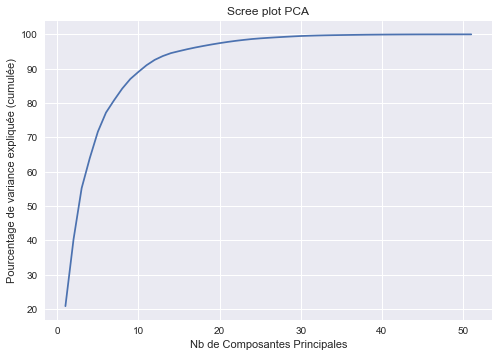

In [14]:
pca_scree = decomposition.PCA(n_components=data_scale.shape[1])
pca_scree.fit(data_scale)
plt.style.use('seaborn')
plt.xlabel('Nb de Composantes Principales')
plt.ylabel('Pourcentage de variance expliquée (cumulée)')
plt.title('Scree plot PCA')
plt.plot(np.arange(1, pca_scree.n_components_ + 1), pca_scree.explained_variance_ratio_.cumsum()*100)

<a id='tsne'></a>
# t-SNE ✨

Données non standardisées

In [15]:
%%time
tsne = manifold.TSNE(random_state=41)
data_tsne = tsne.fit_transform(data)

Wall time: 22.8 s


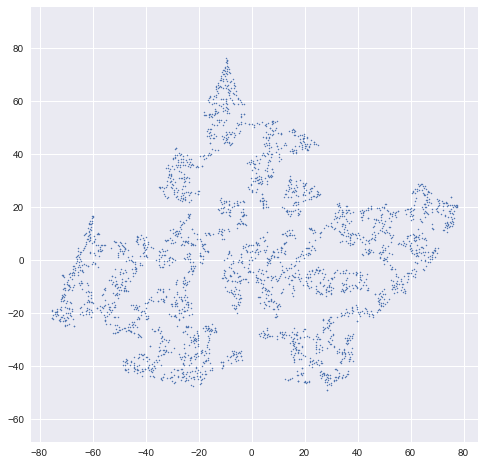

0.8501572012901306


In [16]:
x = [point[0] for point in data_tsne]
y = [point[1] for point in data_tsne]
plt.style.use('seaborn')
plt.figure(figsize=(8,8))
plt.axis('equal')
plt.scatter(x, y, marker='.', s=5)
plt.show()
print(tsne.kl_divergence_)

Données Standardisées

In [17]:
%%time
tsne = manifold.TSNE(init='pca', random_state=41, n_jobs=-1)
data_tsne = tsne.fit_transform(data_scale)

Wall time: 23.6 s


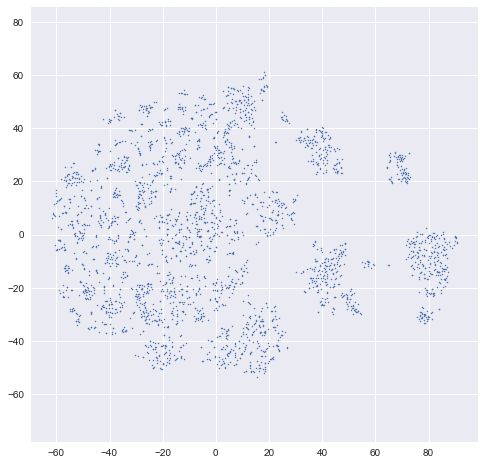

1.30453360080719


In [18]:
x = [point[0] for point in data_tsne]
y = [point[1] for point in data_tsne]
plt.style.use('seaborn')
plt.figure(figsize=(8,8))
plt.axis('equal')
plt.scatter(x, y, marker='.', s=5)
plt.show()
print(tsne.kl_divergence_)

On voit bien ici l'intéret de travailler sur des données standardisées

Fit un kmeans et colorier les points avec les etiquettes du kmeans et vérifier la cohérence du t-sne vis à vis du kmeans. Ensuite essayer la perplexité

<a id='kmeans'></a>
# k-Means 🧶

In [19]:
def launch_kmeans(data, params, run_name):
    
    with mlflow.start_run(run_name=run_name):
        #Create an estimator
        model = KMeans(**params)
        #Save params
        for param, value in model.get_params().items():
            mlflow.log_param(param, value)
        #Fit
        start = time.time()
        model.fit(data)
        elapsed = time.time() - start
        
        
        #Save metrics
        mlflow.log_metric('inertia', model.inertia_)
        mlflow.log_metric('nb_iter', model.n_iter_)
        mlflow.log_metric('training_time', elapsed)
        mlflow.log_metric('silhouette_score', metrics.silhouette_score(data, model.labels_))
        
        #Save model
        mlflow.sklearn.log_model(model, "model")
        
        mlflow.end_run()

In [20]:
runs = mlflow.search_runs('1')

In [21]:
runs[runs['tags.mlflow.runName']!='test'][['tags.mlflow.runName', 'params.n_clusters', 'metrics.inertia', 'metrics.silhouette_score']].sort_values('metrics.silhouette_score', ascending=False)

,tags.mlflow.runName,params.n_clusters,metrics.inertia,metrics.silhouette_score
8,GS_sil_2,2,31150.634832,0.369910
5,GS_sil_5,5,21633.441276,0.193952
6,GS_sil_4,4,24247.857397,0.189334
7,GS_sil_3,3,26977.036396,0.186324
0,GS_sil_10,10,16584.659060,0.158375
...,...,...,...,...
204,GS_5,5,21633.441276,NaN
205,GS_4,4,24247.857397,NaN
206,GS_3,3,26977.036396,NaN
207,GS_2,2,31150.634832,NaN


In [22]:
logged_model = 'file:///C:/Users/S053567/Docs/OpenClassrooms/OC_P05/mlruns/1/c9520ad7bef0449d81f2c0b697be3a2a/artifacts/model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on a Pandas DataFrame.

loaded_model.predict(pd.DataFrame(data_scale))

array([4, 1, 1, ..., 2, 1, 1])

In [26]:
loaded_model.predict(pd.DataFrame(data_scale)).astype('float')

array([4., 1., 1., ..., 2., 1., 1.])

In [17]:
%%time
tsne = manifold.TSNE(init='pca', random_state=41, n_jobs=-1)
data_tsne = tsne.fit_transform(data_scale)

Wall time: 23.6 s


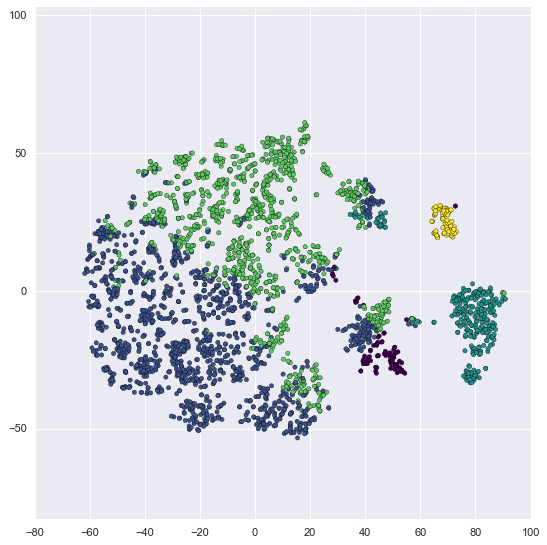

1.30453360080719


In [42]:
x = [point[0] for point in data_tsne]
y = [point[1] for point in data_tsne]
# plt.style.use('seaborn')
plt.figure(figsize=(8,8))
plt.axis('equal')
plt.scatter(x, y, marker='o', s=15, c=loaded_model.predict(pd.DataFrame(data_scale)).astype('float'))
plt.show()
print(tsne.kl_divergence_)

In [37]:
plt.rcParams["image.cmap"] = 'viridis'

In [38]:
plt.rcParams["image.cmap"]

'viridis'

Essayons plusieurs valeurs de perplexité